<a href="https://colab.research.google.com/github/SudhirSaxena/Spark-Program/blob/master/Copy_of_Machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My\ Drive/Machine_translation

/content/drive/My Drive/Machine_translation


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Text in langauge 1 from which conversion to other language will take place
input_text = []
#Text in target langauge to which conversion will take place
target_text = []
#Input of the decoder
target_input_text = []

In [ ]:
count = 0
#We have 1,20,614 samples in our spa.txt file
Num_samples = 10000
for line in open("spa.txt"):
  count = count + 1
  #Our count will be for the number of samples we are going to take to train model on
  if count > Num_samples:
    break
  #As in our spa.txt file our english and spanish text has been separated by a tab so we need to split on tab and if a line doesn't have tab we have to ignore it and move to next line
  if "\t" not in line:
    continue
  #Now splitting lines
  input_t,target_t = line.split("\t")
  #Now we will be adding a <sos> token in our target as it will be input to our decoder
  target_input_txt = "<sos> "+target_t
  #We will also add a <eos> token at end of target_t so as to create the output of decoder
  target_txt = target_t+" <eos>"
  #Now we will be appending the text data to our lists of input_text and target_text
  input_text.append(input_t)
  target_text.append(target_txt)
  target_input_text.append(target_input_txt)

In [ ]:
#Checking the size of the input and output samples created
print("Input samples: ",len(input_text))

Input samples:  10000


Now as we have our input and output data for our encoder decoder architecture what we need to do is to preprocess it so that it can be fed to neural networks

Preprocessing the input text data

In [ ]:
from keras.preprocessing.text import Tokenizer
Maximum_num_words = 20000
tokenizer = Tokenizer(num_words = Maximum_num_words)
tokenizer.fit_on_texts(input_text)
#Converting our sequence of words to sequence of integers
input_sequences = tokenizer.texts_to_sequences(input_text)

Using TensorFlow backend.


In [ ]:
#Word to index for the inputs
word2idx_input = tokenizer.word_index
print(len(word2idx_input))

2364


In [ ]:
#Max length of input sequence
max_i_len = max(len(s) for s in input_sequences)
print("Max_input_length_sequence: ",max_i_len)

Max_input_length_sequence:  5


Preprocessing the output text data keeping the special characters intact else start of sentence and end of sentence won't appear

In [ ]:
#Creating from text to sequence the output text 
tokenizer1 = Tokenizer(num_words = Maximum_num_words,filters = " ")
tokenizer1.fit_on_texts(target_input_text+target_text)
target_input_sequences = tokenizer1.texts_to_sequences(target_input_text)
target_sequences = tokenizer1.texts_to_sequences(target_text)

In [ ]:
#Word to index for the outputs target
word2idx_output = tokenizer1.word_index
print(len(word2idx_output))

6298


In [ ]:
#Maximum length of target sequence
max_o_len = max(len(s) for s in target_sequences)
print("Maximum_output_length_sequence: ",max_o_len)

Maximum_output_length_sequence:  9


Now as we have converted our sequnce of words to sequence of integers next will be to pad them so as to bring all to same length(mostly we do post padding)

Now padding the input, target and target_input sequences as per the max length found in sequences

In [ ]:
from keras.preprocessing.sequence import pad_sequences
encoder_inputs = pad_sequences(input_sequences,maxlen = max_i_len)
decoder_inputs = pad_sequences(target_input_sequences,maxlen = max_o_len,padding = "post")
decoder_outputs = pad_sequences(target_sequences,maxlen = max_o_len,padding = "post")

In [ ]:
#Checking the length of padded_sequences
print("encoder_input_padded_dim: ",encoder_inputs.shape)
print("decoder_input_padded_dim: ",decoder_inputs.shape)
print("decoder_output_padded_dim: ",decoder_outputs.shape)

encoder_input_padded_dim:  (10000, 5)
decoder_input_padded_dim:  (10000, 9)
decoder_output_padded_dim:  (10000, 9)


In [ ]:
#Here we will be using Glove word vectors
#First creating a dictonary of word to vectors(initializing a empty dictionary)
word2vec = {}
with open("glove.6B.100d.txt") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype = "float32")
    word2vec[word] = vec
print("No of word to vectors in glove word 2 vec: ",len(word2vec))
#So here basically we created a dictionary having words as index and corresponding vectors as values

No of word to vectors in glove word 2 vec:  400000


Now next step which we gonna do is create a embedding matrix which we will use for mapping each of the word of our sentence to a vector 

In [ ]:
#These num_words will be our vocabulary size
#Embedding_dim will be the size of our embeddings(word vectors), which will be 100 as in glove 100d each word contain a corresponding vector of 100d
#This plus 1 because word2idx index start from 1
#Taking max_vocab_size to be 20000
Max_vocab_size = 20000
num_words = min(Max_vocab_size,len(word2idx_input)+1)
Embedding_dim = 100
embedding_matrix = np.zeros((num_words,Embedding_dim))
for word,i in word2idx_input.items():
  if i<Max_vocab_size:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
#This is the way we gonna fill our embedding matrix with word vectors

Now creating the embedding layer

In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(num_words,Embedding_dim,weights = [embedding_matrix],input_length = max_i_len)

Now we gonna be creating targets as we can have sparse crossentropy when we have sequences

In [ ]:
decoder_target_one_hot = np.zeros((len(input_text),max_o_len,len(word2idx_output)+1),dtype = "float32")
#Assigning the values
for i,d in enumerate(decoder_outputs):
  for t,word in enumerate(d):
    decoder_target_one_hot[i,t,word] = 1

Now next we will build our model

In [ ]:
from keras.models import Model
from keras.layers import LSTM,Dense,Input
#Defining the latent dimension
M = 512

In [ ]:
#Setting the encoder
encoder_input = Input(shape = (max_i_len,))
x = embedding_layer(encoder_input)
encoder = LSTM(M,return_state = True,dropout = 0.5)
#If we would have used GRU we would not c(cell state)
encoder_output,h,c = encoder(x)
#Keeping only the states to pass to decoder
encoder_states = [h,c]

#Setting the decoder
decoder_input = Input(shape = (max_o_len,))
#We will b creating a different embedding for the decoder as here we are generating different language
decoder_embedding = Embedding(len(word2idx_output)+1,M)
decoder_input_x = decoder_embedding(decoder_input)
decoder_lstm = LSTM(M,return_sequences = True,return_state = True,dropout = 0.5)
#Since we will be returning output at each time stamp n decoder so decoder return_sequence will be True
decoder_output,_,_ = decoder_lstm(decoder_input_x,initial_state = encoder_states)
decoder_dense = Dense(len(word2idx_output)+1,activation = "softmax")
decoder_output = decoder_dense(decoder_output)
model = Model([encoder_input,decoder_input],decoder_output)

#Compiling the model
model.compile(optimizer = "rmsprop",loss = "categorical_crossentropy",metrics = ["accuracy"])

In [ ]:
ht = model.fit([encoder_inputs,decoder_inputs],decoder_target_one_hot,batch_size = 128,epochs = 50,validation_split = 0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 5s 638us/step - loss: 0.9273 - accuracy: 0.8176 - val_loss: 1.9600 - val_accuracy: 0.7417
Epoch 2/50
8000/8000 [==============================] - 5s 642us/step - loss: 0.8705 - accuracy: 0.8241 - val_loss: 1.9835 - val_accuracy: 0.7412
Epoch 3/50
8000/8000 [==============================] - 5s 644us/step - loss: 0.8182 - accuracy: 0.8316 - val_loss: 1.9681 - val_accuracy: 0.7433
Epoch 4/50
8000/8000 [==============================] - 5s 651us/step - loss: 0.7677 - accuracy: 0.8380 - val_loss: 1.9633 - val_accuracy: 0.7432
Epoch 5/50
8000/8000 [==============================] - 5s 644us/step - loss: 0.7234 - accuracy: 0.8461 - val_loss: 1.9479 - val_accuracy: 0.7434
Epoch 6/50
8000/8000 [==============================] - 5s 640us/step - loss: 0.6805 - accuracy: 0.8522 - val_loss: 1.9322 - val_accuracy: 0.7459
Epoch 7/50
8000/8000 [==============================] - 5s 643us/step - loss

From the epochs we can see that overfitting accured

PLotting the accuracy and loss curve

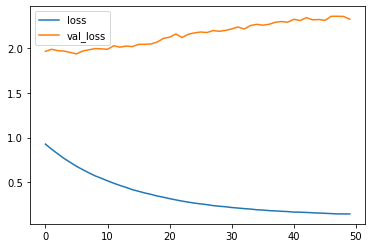

In [ ]:
plt.plot(ht.history["loss"],label = "loss")
plt.plot(ht.history["val_loss"],label = "val_loss")
plt.legend()
plt.show()

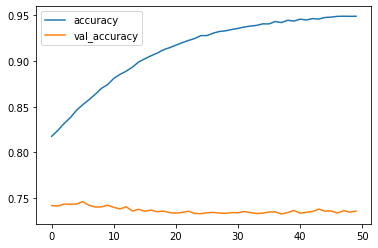

In [ ]:
plt.plot(ht.history["accuracy"],label = "accuracy")
plt.plot(ht.history["val_accuracy"],label = "val_accuracy")
plt.legend()
plt.show()

In [ ]:
model.save("model_tranlation1.h5")

Now what we gonna do is generate a sampling model which we will use for generating predictions

In [ ]:
encoder_model = Model(encoder_input,encoder_states)
decoder_state_input_h = Input(shape = (M,))
decoder_state_input_c = Input(shape = (M,))
decoder_state_inputs = [decoder_state_input_h,decoder_state_input_c]

decoder_input_single = Input(shape = (1,))
decoder_input_single_x = decoder_embedding(decoder_input_single)
decoder_output_x,h,c = decoder_lstm(decoder_input_single_x,initial_state = decoder_state_inputs)

decoder_state = [h,c]
decoder_output_x = decoder_dense(decoder_output_x)

decoder_model = Model([decoder_input_single]+decoder_state_inputs,[decoder_output_x]+decoder_state)

In [ ]:
idx2word_eng = {v:k for k,v in word2idx_input.items()}
idx2word_spa = {a:b for b,a in word2idx_output.items()}

In [ ]:
for i in range(1,20):
  print(idx2word_eng[i])

i
tom
you
is
it
a
i'm
me
he
this
are
we
it's
go
do
that
was
my
they


In [ ]:
for i in range(1,20):
  print(idx2word_spa[i])

<sos>
<eos>
es
tom
a
no
me
un
está
lo
yo
estoy
la
de
se
el
él
soy
tom.



In [ ]:
def decode_sequence(input_seq):
  #Encoding the input as a state vector
  state_value = encoder_model.predict(input_seq)
  #Generating a input target sequence of length one
  target_seq = np.zeros((1,1))
  #Putting the first character of target sequence by start character
  target_seq[0,0] = word2idx_output["<sos>"]
  #If we get eos we break
  eos = word2idx_output["<eos>"]
  #Now we gonna be creating a translation and we will create a output list in which we will append all the generated words
  output_sentence = []
  for _ in range(max_o_len):
    output,h,c = decoder_model.predict([target_seq]+state_value)
    #Getting the next word using argmax
    idx = np.argmax(output[0,0,:])
    #If eos encountered break
    if eos == idx:
      break
    word = " "
    if idx>0:
      word = idx2word_spa[idx]
      output_sentence.append(word)
    #Updating the decoders input and setting it to the word just predicted
    target_seq[0,0] = idx
    #Updating states
    state_value = [h,c]
  return " ".join(output_sentence)

This decode_sequence function will generate the sentences and now we will call this inside a loop to generate sentences

In [ ]:
while True:
  #First prediction will be random from the input text data
  i = np.random.choice(len(input_text))
  input_seq = encoder_inputs[i:i+1]
  #Translating the input sentence
  trans = decode_sequence(input_seq)
  print("##@@##@@##@@##@@##@@##@@##@@##@@##")
  print("Input text: ",input_text[i])
  print("Translated text: ",trans)
  ans = input("Translation continuing status yes or no ")
  if ans and ans.lower().startswith("n"):
    break

##@@##@@##@@##@@##@@##@@##@@##@@##
Input text:  God exists.
Translated text:  dios existe.

Translation continuing status yes or no yes
##@@##@@##@@##@@##@@##@@##@@##@@##
Input text:  Who panicked?
Translated text:  ¿quién entró en pánico?

Translation continuing status yes or no yes
##@@##@@##@@##@@##@@##@@##@@##@@##
Input text:  Tom was framed.
Translated text:  tom fue enmarcado.

Translation continuing status yes or no yes
##@@##@@##@@##@@##@@##@@##@@##@@##
Input text:  I needed that.
Translated text:  yo necesité eso.

Translation continuing status yes or no yes
##@@##@@##@@##@@##@@##@@##@@##@@##
Input text:  Tom is bald.
Translated text:  tom está pelón.

Translation continuing status yes or no yes
##@@##@@##@@##@@##@@##@@##@@##@@##
Input text:  He is bankrupt.
Translated text:  él está arruinado.

Translation continuing status yes or no yes
##@@##@@##@@##@@##@@##@@##@@##@@##
Input text:  He gave up.
Translated text:  cedió.

Translation continuing status yes or no yes
##@@##@@##

Basically encoding our input text to a vector hurt performance because we folds each and every input sequence regardless of their length to the same vector length and it will be very much better if our decoder make use of all the information rather than only the information from the last hidden state and that is where the attention mechanism comes to rescue